## Importing packages

In [1]:
#### COde is bugged

In [2]:
import pandas as pd
import numpy as np
import ccxt
import ta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## Importing data

In [3]:
country = 'US'
symbol = "BTC/USDT"
timeframe = '1d'
limit = None

In [4]:
exchange = ccxt.binance()

ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit)
# Create a DataFrame
data = pd.DataFrame(ohlcv, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
# Convert timestamp to datetime
data['Date'] = pd.to_datetime(data['Date'], unit='ms')

In [5]:
#data['Date'] = data['Date'].dt.tz_localize(None)

In [6]:
data2 = pd.read_pickle('BTC-Predictions.pkl') #BTC-Predictions.csv or BTC-Predictions-v2.csv or SPY-Predictions.csv
data2['Date']= pd.to_datetime(data2['Date'])

In [7]:
data2

,Date,Signal
0,2023-09-17,-1.0
1,2023-09-18,1.0
2,2023-09-19,1.0
3,2023-09-20,1.0
4,2023-09-21,-1.0
...,...,...
415,2024-11-05,-1.0
416,2024-11-06,-1.0
417,2024-11-07,-1.0
418,2024-11-08,1.0


In [8]:
data = pd.merge(data, data2, on='Date')
data

,Date,Open,High,Low,Close,Volume,Signal
0,2023-09-17,26559.67,26623.25,26399.00,26527.51,12998.102770,-1.0
1,2023-09-18,26527.50,27409.00,26377.35,26762.51,43000.432560,1.0
2,2023-09-19,26762.50,27483.57,26667.79,27210.26,36190.521870,1.0
3,2023-09-20,27210.25,27388.63,26800.00,27125.00,34207.218670,1.0
4,2023-09-21,27125.01,27159.60,26377.70,26568.08,34476.826620,-1.0
...,...,...,...,...,...,...,...
415,2024-11-05,67850.01,70577.91,67476.63,69372.01,33355.068880,-1.0
416,2024-11-06,69372.01,76400.00,69298.00,75571.99,104126.994787,-1.0
417,2024-11-07,75571.99,76849.99,74416.00,75857.89,44869.422345,-1.0
418,2024-11-08,75857.89,77199.99,75555.00,76509.78,36521.099583,1.0


## Define Strategy

In [9]:
# Do not change

position_sizing = 1 # leverage
shorting = False

if shorting == False:
    bearish_pos = 0.5
else:
    bearish_pos = -1

data['Position'] = data['Signal'].shift(1)

data['Position'] = np.where(data['Position'] > 0, position_sizing, data['Position'])
data['Position'] = np.where(data['Position'] < 0, bearish_pos, data['Position']) 

In [10]:
data.head()

,Date,Open,High,Low,Close,Volume,Signal,Position
0,2023-09-17,26559.67,26623.25,26399.00,26527.51,12998.10277,-1.0,NaN
1,2023-09-18,26527.50,27409.00,26377.35,26762.51,43000.43256,1.0,0.5
2,2023-09-19,26762.50,27483.57,26667.79,27210.26,36190.52187,1.0,1.0
3,2023-09-20,27210.25,27388.63,26800.00,27125.00,34207.21867,1.0,1.0
4,2023-09-21,27125.01,27159.60,26377.70,26568.08,34476.82662,-1.0,1.0


In [11]:
data['Returns'] = data['Close'].pct_change()
data['Strategy_Returns'] = data['Returns'] * data['Position']

In [12]:
#data['Strategy_Returns'] = data['Strategy_Returns'] 

In [13]:
data['Cumul_Returns'] = data['Returns'] +1 # ????
data.loc[0, 'Cumul_Returns'] = data['Close'].iloc[0]
data['Cumul_Returns'] = (data['Cumul_Returns']).cumprod()

data['Cumul_Strat_Returns'] = data['Strategy_Returns'] +1
data.loc[0, 'Cumul_Strat_Returns'] = data['Close'].iloc[0]
data['Cumul_Strat_Returns'] = (data['Cumul_Strat_Returns']).cumprod()

In [14]:
data.head(5)

,Date,Open,High,Low,Close,Volume,Signal,Position,Returns,Strategy_Returns,Cumul_Returns,Cumul_Strat_Returns
0,2023-09-17,26559.67,26623.25,26399.00,26527.51,12998.10277,-1.0,NaN,NaN,NaN,26527.51,26527.510000
1,2023-09-18,26527.50,27409.00,26377.35,26762.51,43000.43256,1.0,0.5,0.008859,0.004429,26762.51,26645.010000
2,2023-09-19,26762.50,27483.57,26667.79,27210.26,36190.52187,1.0,1.0,0.016730,0.016730,27210.26,27090.794167
3,2023-09-20,27210.25,27388.63,26800.00,27125.00,34207.21867,1.0,1.0,-0.003133,-0.003133,27125.00,27005.908498
4,2023-09-21,27125.01,27159.60,26377.70,26568.08,34476.82662,-1.0,1.0,-0.020532,-0.020532,26568.08,26451.433639


In [15]:
data['EMA'] = ta.trend.EMAIndicator(close=data['Cumul_Strat_Returns'], window=10).ema_indicator() * 1
data = data.dropna()
data = data.copy().reset_index()
data

,index,Date,Open,High,Low,Close,Volume,Signal,Position,Returns,Strategy_Returns,Cumul_Returns,Cumul_Strat_Returns,EMA
0,29,2023-10-16,27154.14,30000.00,27112.66,28500.78,78399.224450,1.0,1.0,0.049592,0.049592,28500.78,27892.301257,26670.147989
1,30,2023-10-17,28500.77,28613.65,28069.32,28395.91,38428.445320,-1.0,1.0,-0.003680,-0.003680,28395.91,27789.670184,26742.375228
2,31,2023-10-18,28395.91,28982.36,28142.87,28320.00,32162.475910,-1.0,0.5,-0.002673,-0.001337,28320.00,27752.525506,26807.546214
3,32,2023-10-19,28320.00,28916.89,28100.66,28713.71,35895.501790,-1.0,0.5,0.013902,0.006951,28713.71,27945.435937,26880.958454
4,33,2023-10-20,28713.71,30207.55,28578.29,29669.04,59422.099200,1.0,0.5,0.033271,0.016635,29669.04,28410.320365,26979.626964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,415,2024-11-05,67850.01,70577.91,67476.63,69372.01,33355.068880,-1.0,1.0,0.022432,0.022432,69372.01,60067.191108,58733.529315
387,416,2024-11-06,69372.01,76400.00,69298.00,75571.99,104126.994787,-1.0,0.5,0.089373,0.044686,75571.99,62751.381630,58992.745593
388,417,2024-11-07,75571.99,76849.99,74416.00,75857.89,44869.422345,-1.0,0.5,0.003783,0.001892,75857.89,62870.080503,59242.896233
389,418,2024-11-08,75857.89,77199.99,75555.00,76509.78,36521.099583,1.0,0.5,0.008594,0.004297,76509.78,63140.219685,59494.336455


In [16]:
data['Signal 2'] = np.where(data['Cumul_Strat_Returns'] >= data['EMA'], data['Signal'], -2) # Reviewing signal to filter PROFIT with EMA.

In [17]:
position_sizing = 1 # leverage
shorting = True

if shorting is False:
    bearish_pos = position_sizing/2
    bearish_pos_2 = 0
else:
    bearish_pos = position_sizing/2
    bearish_pos_2 = -1 * position_sizing

data['Position 2'] = data['Signal 2']

data['Position 2'] = np.where(data['Position 2'] == 1, position_sizing, data['Position 2'])
data['Position 2'] = np.where(data['Position 2'] == -1, bearish_pos, data['Position 2']) 
data['Position 2'] = np.where(data['Position 2'] == -2, bearish_pos_2, data['Position 2']) 

In [18]:
data['Strategy_Returns 2'] = data['Returns'] * data['Position 2']

data['Cumul_Strat_Returns 2'] = data['Strategy_Returns 2'] +1
data.loc[0, 'Cumul_Strat_Returns 2'] = data['Close'].iloc[0]
data['Cumul_Strat_Returns 2'] = (data['Cumul_Strat_Returns 2']).cumprod()

In [19]:
data.loc[0, 'Cumul_Strat_Returns 2'] = data['Close'].iloc[0]
data['Cumul_Strat_Returns 2']

0       28500.780000
1       28448.345000
2       28410.319913
3       28607.802736
4       29559.609109
           ...      
386    265450.604155
387    277312.653682
388    277837.211046
389    280224.824246
390    280838.969242
Name: Cumul_Strat_Returns 2, Length: 391, dtype: float64

In [20]:
data.index = data['Date']

In [21]:
growth_1 = float(data.tail(1)['Cumul_Returns'] / data['Close'].iloc[0] * 100)
growth_2 = float(data.tail(1)['Cumul_Strat_Returns'] / data['Close'].iloc[0] * 100)
growth_3 = float(data.tail(1)['Cumul_Strat_Returns 2'] / data['Close'].iloc[0] * 100)

C:\Users\neopa\AppData\Local\Temp\ipykernel_15176\580300260.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  growth_1 = float(data.tail(1)['Cumul_Returns'] / data['Close'].iloc[0] * 100)
C:\Users\neopa\AppData\Local\Temp\ipykernel_15176\580300260.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  growth_2 = float(data.tail(1)['Cumul_Strat_Returns'] / data['Close'].iloc[0] * 100)
C:\Users\neopa\AppData\Local\Temp\ipykernel_15176\580300260.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  growth_3 = float(data.tail(1)['Cumul_Strat_Returns 2'] / data['Close'].iloc[0] * 100)


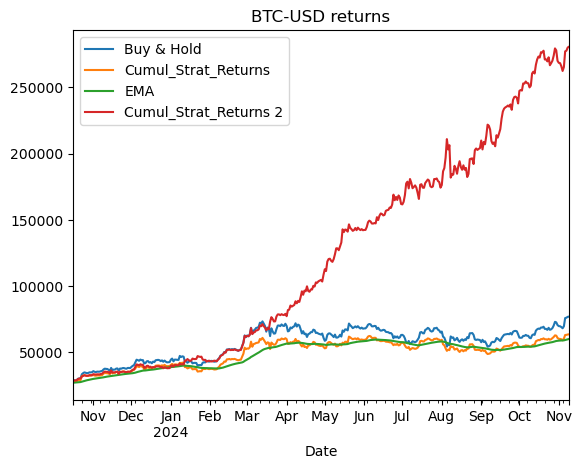

Total return from Buy & Hold: 269.0363561979709 %
Total return from Strategy 1: 222.02409461395436 %
Total return from Strategy 2: 985.3729239756135 %


In [22]:
data = data.rename(columns={'Cumul_Returns':'Buy & Hold'})
data[['Buy & Hold', 'Cumul_Strat_Returns', 'EMA','Cumul_Strat_Returns 2']].plot()
#data[['Cumul_Strat_Returns', 'EMA']].plot()
plt.title('BTC-USD returns')
plt.show()

print(f'Total return from Buy & Hold: {growth_1} %')
print(f'Total return from Strategy 1: {growth_2} %')
print(f'Total return from Strategy 2: {growth_3} %')

In [23]:
data

,index,Date,Open,High,Low,Close,Volume,Signal,Position,Returns,Strategy_Returns,Buy & Hold,Cumul_Strat_Returns,EMA,Signal 2,Position 2,Strategy_Returns 2,Cumul_Strat_Returns 2
Date,,,,,,,,,,,,,,,,,,
2023-10-16,29,2023-10-16,27154.14,30000.00,27112.66,28500.78,78399.224450,1.0,1.0,0.049592,0.049592,28500.78,27892.301257,26670.147989,1.0,1.0,0.049592,28500.780000
2023-10-17,30,2023-10-17,28500.77,28613.65,28069.32,28395.91,38428.445320,-1.0,1.0,-0.003680,-0.003680,28395.91,27789.670184,26742.375228,-1.0,0.5,-0.001840,28448.345000
2023-10-18,31,2023-10-18,28395.91,28982.36,28142.87,28320.00,32162.475910,-1.0,0.5,-0.002673,-0.001337,28320.00,27752.525506,26807.546214,-1.0,0.5,-0.001337,28410.319913
2023-10-19,32,2023-10-19,28320.00,28916.89,28100.66,28713.71,35895.501790,-1.0,0.5,0.013902,0.006951,28713.71,27945.435937,26880.958454,-1.0,0.5,0.006951,28607.802736
2023-10-20,33,2023-10-20,28713.71,30207.55,28578.29,29669.04,59422.099200,1.0,0.5,0.033271,0.016635,29669.04,28410.320365,26979.626964,1.0,1.0,0.033271,29559.609109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-05,415,2024-11-05,67850.01,70577.91,67476.63,69372.01,33355.068880,-1.0,1.0,0.022432,0.022432,69372.01,60067.191108,58733.529315,-1.0,0.5,0.011216,265450.604155
2024-11-06,416,2024-11-06,69372.01,76400.00,69298.00,75571.99,104126.994787,-1.0,0.5,0.089373,0.044686,75571.99,62751.381630,58992.745593,-1.0,0.5,0.044686,277312.653682
2024-11-07,417,2024-11-07,75571.99,76849.99,74416.00,75857.89,44869.422345,-1.0,0.5,0.003783,0.001892,75857.89,62870.080503,59242.896233,-1.0,0.5,0.001892,277837.211046


In [24]:
# Currently bugged, fix later
"""
total_return = data['Strategy_Returns'].sum()
sharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * np.sqrt(252)
cumulative_returns = data['Strategy_Returns'].cumsum()
running_max = cumulative_returns.cummax()
drawdown = cumulative_returns - running_max
max_drawdown = drawdown.min()
print(f'total_return = {total_return}')
print(f'sharpe_ratio = {sharpe_ratio}')
print(f'max_drawdown = {max_drawdown}')
"""
#

"\ntotal_return = data['Strategy_Returns'].sum()\nsharpe_ratio = (data['Strategy_Returns'].mean() / data['Strategy_Returns'].std()) * np.sqrt(252)\ncumulative_returns = data['Strategy_Returns'].cumsum()\nrunning_max = cumulative_returns.cummax()\ndrawdown = cumulative_returns - running_max\nmax_drawdown = drawdown.min()\nprint(f'total_return = {total_return}')\nprint(f'sharpe_ratio = {sharpe_ratio}')\nprint(f'max_drawdown = {max_drawdown}')\n"

In [25]:
Roll_Max = data['Close'].rolling(9999, min_periods=1).max()
Daily_Drawdown = data['Close']/Roll_Max - 1.0

Max_Daily_Drawdown = Daily_Drawdown.rolling(9999, min_periods=1).min()
Max_Daily_Drawdown.min()

np.float64(-0.261513750538678)

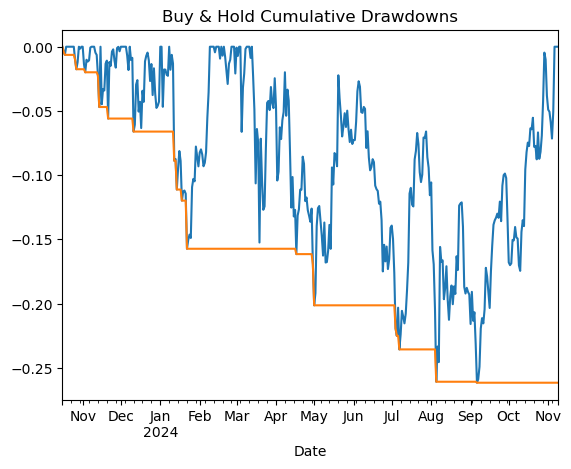

In [26]:
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
plt.title('Buy & Hold Cumulative Drawdowns')
plt.show()

In [27]:
Roll_Max = data['Cumul_Strat_Returns'].rolling(9999, min_periods=1).max()
Daily_Drawdown = data['Cumul_Strat_Returns']/Roll_Max - 1.0

Max_Daily_Drawdown = Daily_Drawdown.rolling(9999, min_periods=1).min()
Max_Daily_Drawdown.min()

np.float64(-0.22016176112161523)

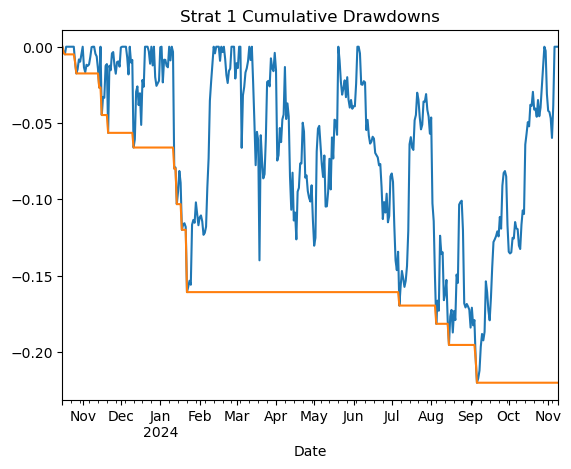

In [28]:
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
plt.title('Strat 1 Cumulative Drawdowns')
plt.show()

In [29]:
Roll_Max = data['Cumul_Strat_Returns 2'].rolling(9999, min_periods=1).max()
Daily_Drawdown = data['Cumul_Strat_Returns 2']/Roll_Max - 1.0

Max_Daily_Drawdown = Daily_Drawdown.rolling(9999, min_periods=1).min()

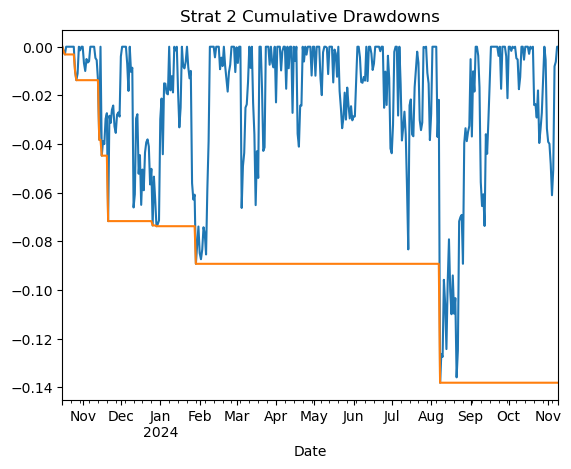

np.float64(-0.1380638588556966)

In [30]:
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot()
plt.title('Strat 2 Cumulative Drawdowns')
plt.show()
Max_Daily_Drawdown.min()

In [31]:
Daily_Drawdown[-30:]

Date
2024-10-11    0.000000
2024-10-12    0.000000
2024-10-13   -0.005319
2024-10-14    0.000000
2024-10-15    0.000000
2024-10-16    0.000000
2024-10-17   -0.002932
2024-10-18    0.000000
2024-10-19   -0.000731
2024-10-20    0.000000
2024-10-21   -0.023967
2024-10-22   -0.023616
2024-10-23   -0.029099
2024-10-24   -0.017961
2024-10-25   -0.039560
2024-10-26   -0.033880
2024-10-27   -0.027192
2024-10-28   -0.013316
2024-10-29    0.000000
2024-10-30   -0.005385
2024-10-31   -0.033606
2024-11-01   -0.039078
2024-11-02   -0.039917
2024-11-03   -0.048203
2024-11-04   -0.061018
2024-11-05   -0.050486
2024-11-06   -0.008056
2024-11-07   -0.006179
2024-11-08    0.000000
2024-11-09    0.000000
Name: Cumul_Strat_Returns 2, dtype: float64

In [32]:
data['Position']

Date
2023-10-16    1.0
2023-10-17    1.0
2023-10-18    0.5
2023-10-19    0.5
2023-10-20    0.5
             ... 
2024-11-05    1.0
2024-11-06    0.5
2024-11-07    0.5
2024-11-08    0.5
2024-11-09    1.0
Name: Position, Length: 391, dtype: float64